C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  

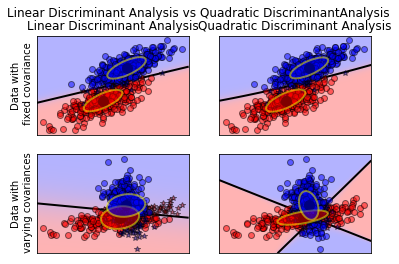

In [6]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariances=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant'
             'Analysis')
plt.show()

In [20]:
print(X)
print()
print(y)

[[  2.00078604  -2.9678846 ]
 [ 11.204466     1.17977451]
 [ -4.8863894   -5.10330501]
 ..., 
 [ -1.07517133  12.41521218]
 [  2.1875549    3.26267053]
 [ -0.17940721  -5.23381655]]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  

In [125]:
import pandas as pd 

df=pd.read_csv("hour.csv")
df.head(7)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,Start,End,Duration
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,NaN,NaN,NaN
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,NaN,NaN,NaN
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,NaN,NaN,NaN
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,NaN,NaN,NaN
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,NaN,NaN,NaN
5,6,1/1/2011,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,NaN,NaN,NaN
6,7,1/1/2011,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,NaN,NaN,NaN


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\covariance\empirical_covariance_.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


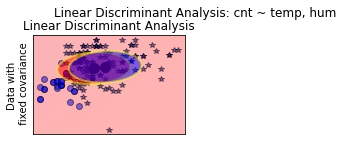

In [28]:
# Instruction 3: Linear classifier Vs Quandratic classifier

from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    X = df.as_matrix(columns = ['temp','hum'])
    y = np.array(df['cnt'])
    return X, y

# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')
    
for i, (X, y) in enumerate([dataset_fixed_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

plt.suptitle('Linear Discriminant Analysis: cnt ~ temp, hum')
plt.show()

In [23]:
X = df.as_matrix(columns = ['temp','weathersit'])
y = np.array(df['cnt'])

print(X)
print(y)

[[ 0.24  1.  ]
 [ 0.22  1.  ]
 [ 0.22  1.  ]
 ..., 
 [ 0.26  1.  ]
 [ 0.26  1.  ]
 [ 0.26  1.  ]]
[16 40 32 ..., 90 61 49]


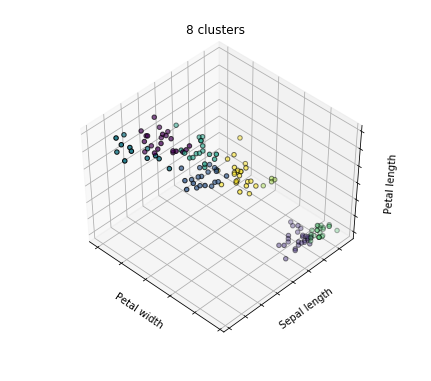

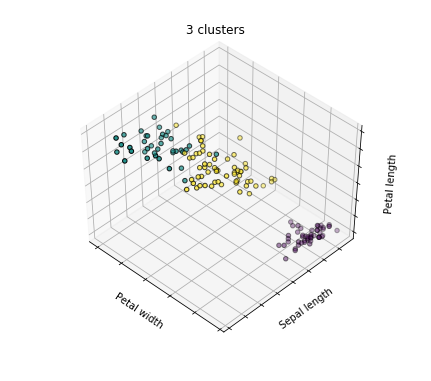

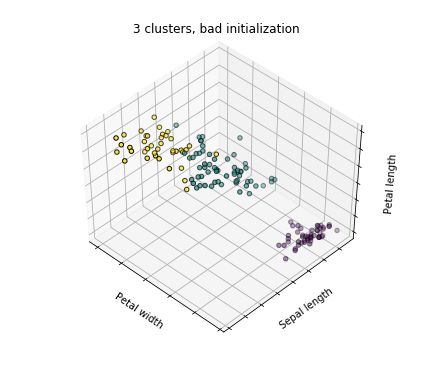

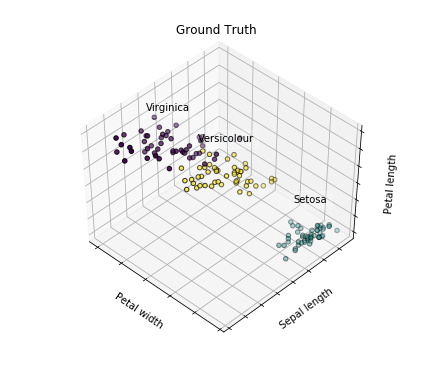

In [30]:
import numpy as np
import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                               init='random'))]

fignum = 1
titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(6, 5))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(6, 5))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground Truth')
ax.dist = 12

plt.show()

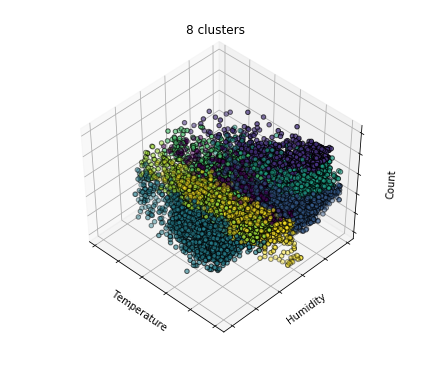

In [35]:
import numpy as np
import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

X = df.as_matrix(columns = ['temp', 'hum'])
y = np.array(df['cnt'])

estimators = [('k_means_iris_8', KMeans(n_clusters=8))]

fignum = 1
titles = ['8 clusters']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(6, 5))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(y, X[:, 0], X[:, 1],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Humidity')
    ax.set_zlabel('Count')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

plt.show()

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')


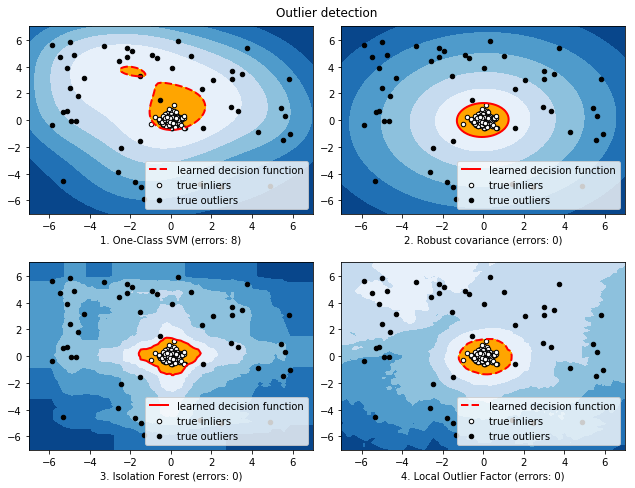

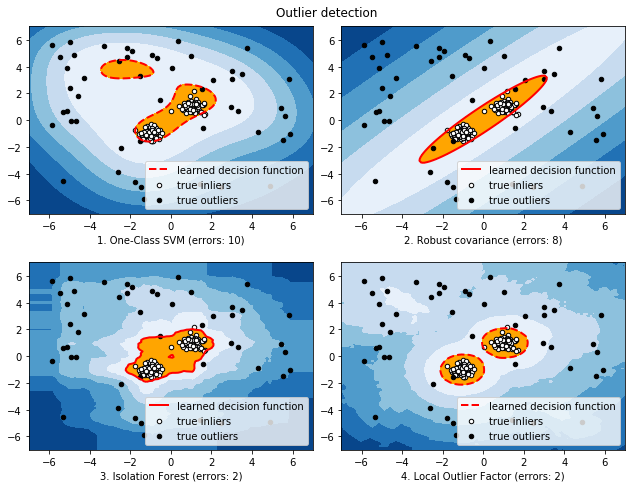

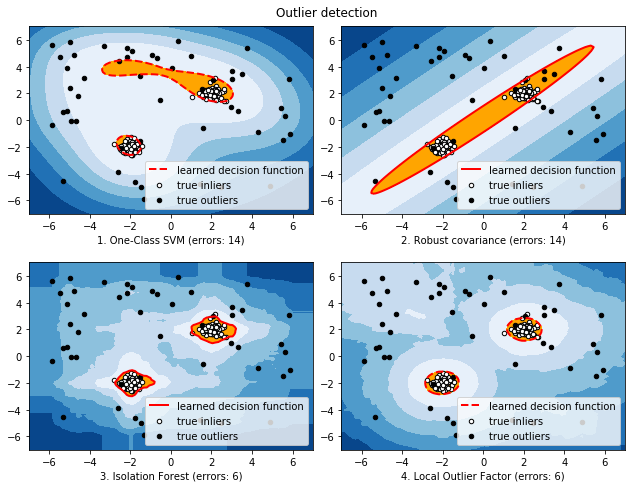

In [36]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()

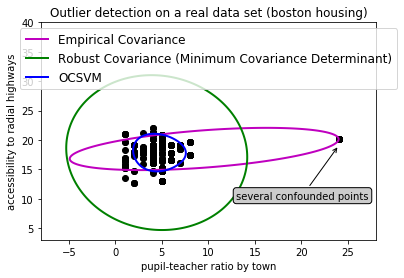

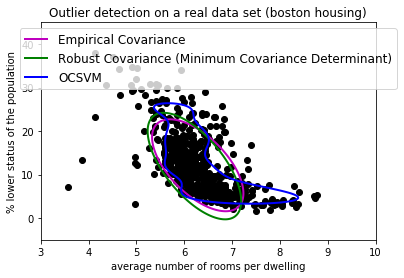

In [37]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston

# Get data
X1 = load_boston()['data'][:, [8, 10]]  # two clusters
X2 = load_boston()['data'][:, [5, 12]]  # "banana"-shaped

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05)}
colors = ['m', 'g', 'b']
legend1 = {}
legend2 = {}

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    plt.figure(2)
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list(legend2.values())
legend2_keys_list = list(legend2.keys())

plt.figure(2)  # "banana" shape
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X2[:, 0], X2[:, 1], color='black')
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend((legend2_values_list[0].collections[0],
            legend2_values_list[1].collections[0],
            legend2_values_list[2].collections[0]),
           (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")

plt.show()

In [39]:
X1 = load_boston()['data'][:, [8, 10]]
print(X1)

EllipticEnvelope(contamination=0.261).fit(X1)


[[  1.   15.3]
 [  2.   17.8]
 [  2.   17.8]
 ..., 
 [  1.   21. ]
 [  1.   21. ]
 [  1.   21. ]]


EllipticEnvelope(assume_centered=False, contamination=0.261,
         random_state=None, store_precision=True, support_fraction=None)

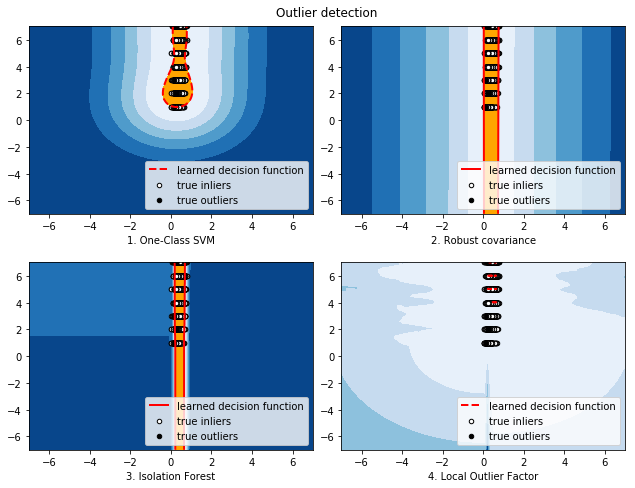

In [11]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
X = df.as_matrix(columns = ['temp', 'cnt'])

# Fit the model
plt.figure(figsize=(9, 7))
for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
    #n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
    if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
        Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(2, 2, i + 1)
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
    b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
    c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
    subplot.set_xlabel("%d. %s" % (i + 1, clf_name))
    subplot.set_xlim((-7, 7))
    subplot.set_ylim((-7, 7))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")

plt.show()

Automatically created module for IPython interactive environment


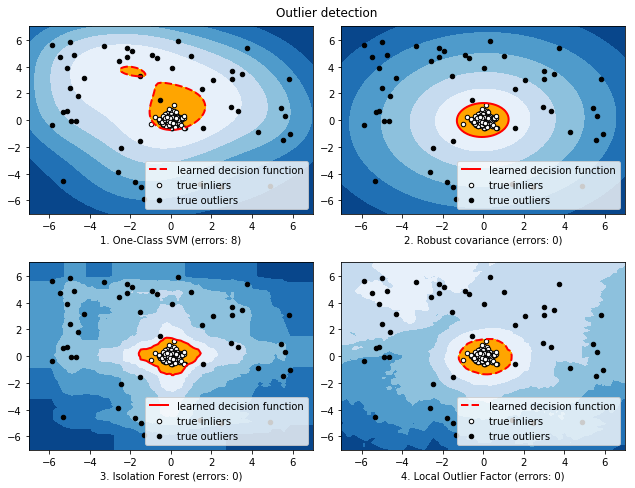

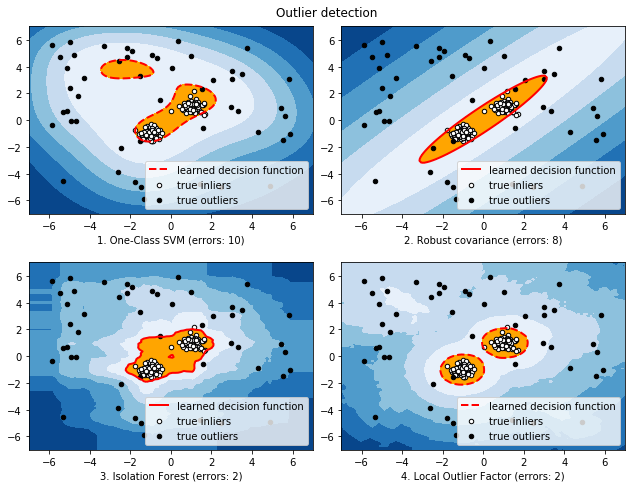

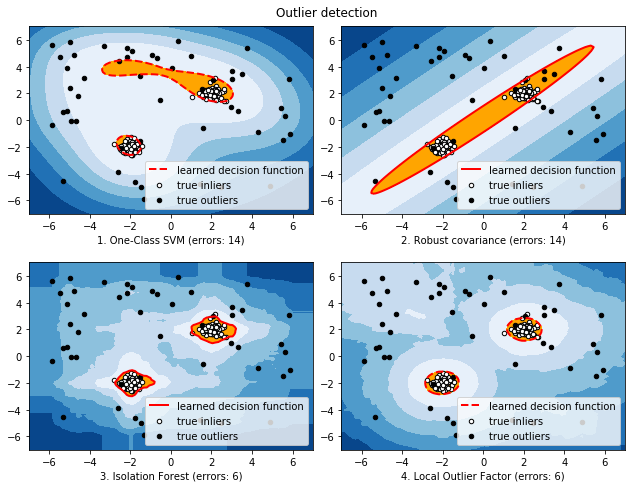

In [7]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()


In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()


Automatically created module for IPython interactive environment


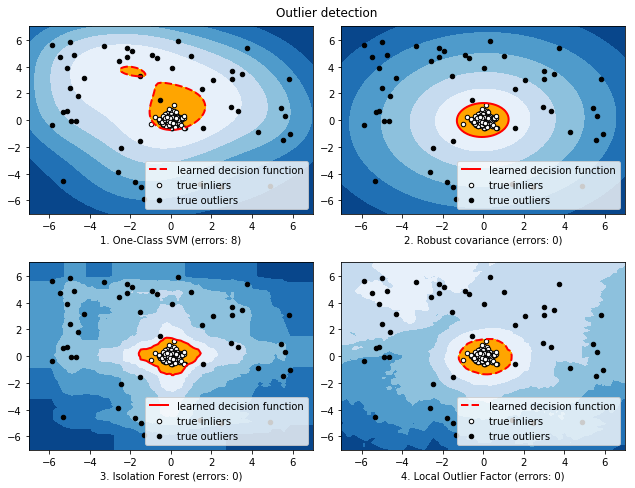

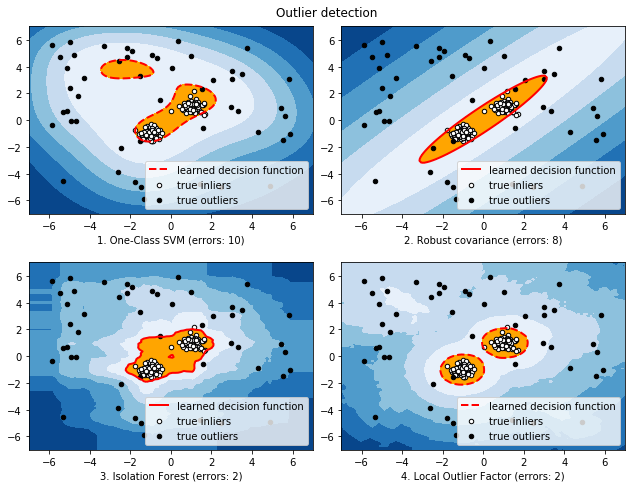

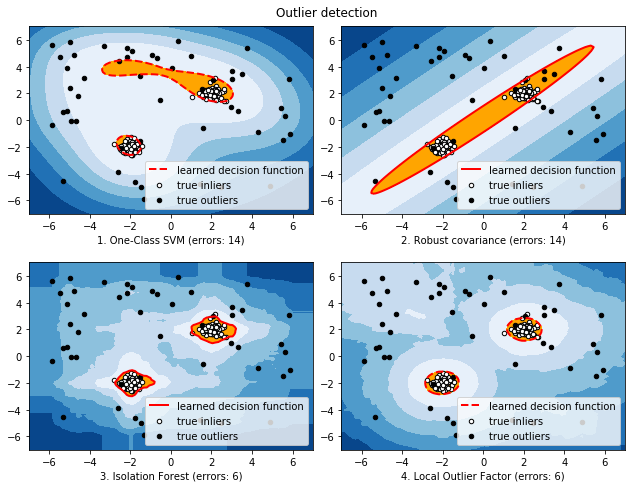

In [1]:

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()

F


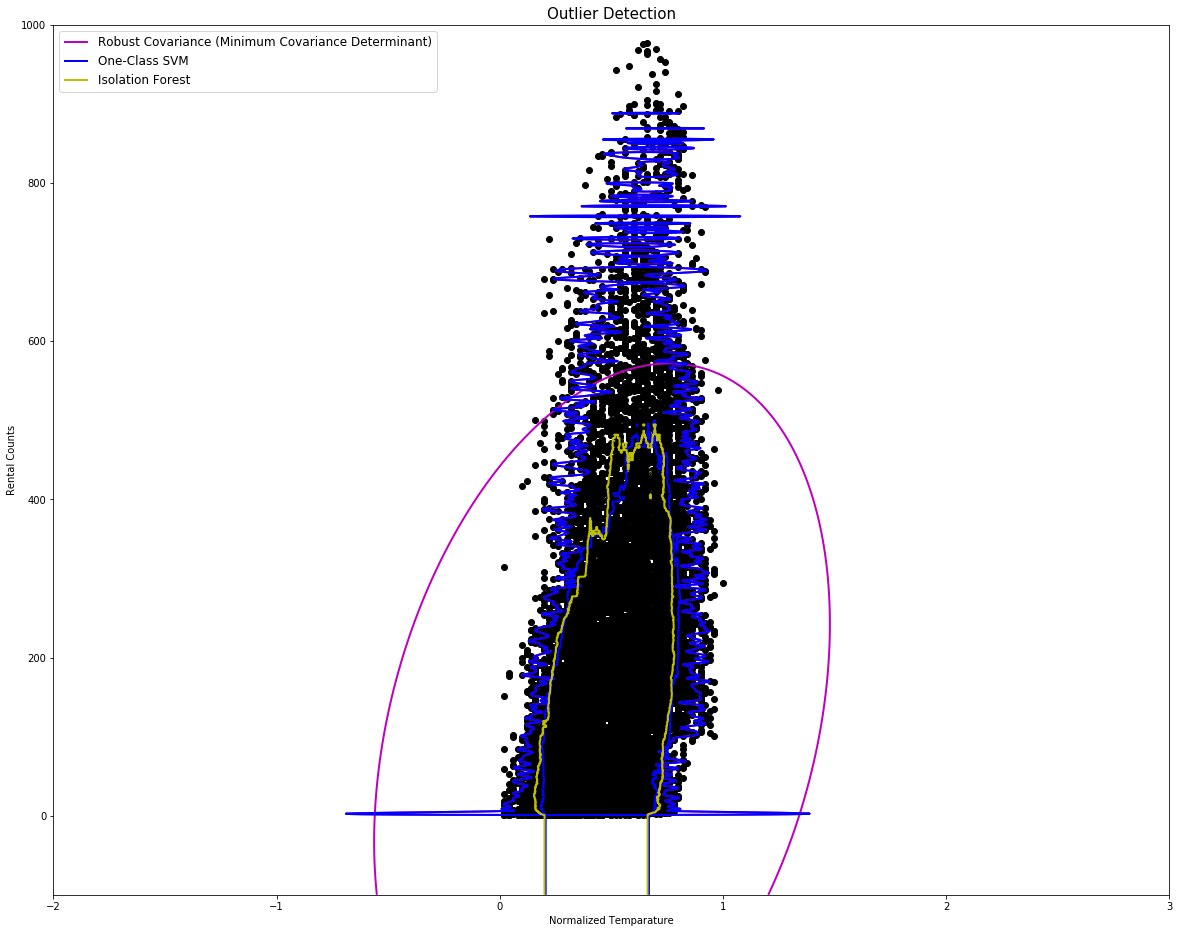

In [9]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston
import pylab

# Get data
X = df.as_matrix(columns = ['temp', 'cnt'])
#X1 = [df["logged_living"], df["logged_price"]]

# Define "classifiers" to be used
classifiers = {"Robust Covariance (Minimum Covariance Determinant)":
               EllipticEnvelope(contamination = 0.05),
               "One-Class SVM": OneClassSVM(nu=0.05, gamma=0.05),
               "Isolation Forest": IsolationForest(contamination=0.05)}

# ,"One-Class SVM": OneClassSVM(nu=0.261, gamma=0.05)
colors = ['m', 'b', 'y']
legend1 = {}


# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-2, 3, 500), np.linspace(-100, 1000, 5000))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(20, 16))
    clf.fit(X)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

print("F")

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(20, 16)) 
plt.title("Outlier Detection", fontsize = 15)
plt.scatter(X[:, 0], X[:, 1], color='black')
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=12))

plt.xlabel("Normalized Temparature")
plt.ylabel("Rental Counts")

#pylab.save("Outlier Detection MCD")
pylab.savefig("Outlier Detection_Emporocal, Roubst, OCSVM")
plt.show()

Corr(X)
[[ 1.   -0.32]
 [-0.32  1.  ]]
Corr(Y)
[[ 1.   -0.06]
 [-0.06  1.  ]]


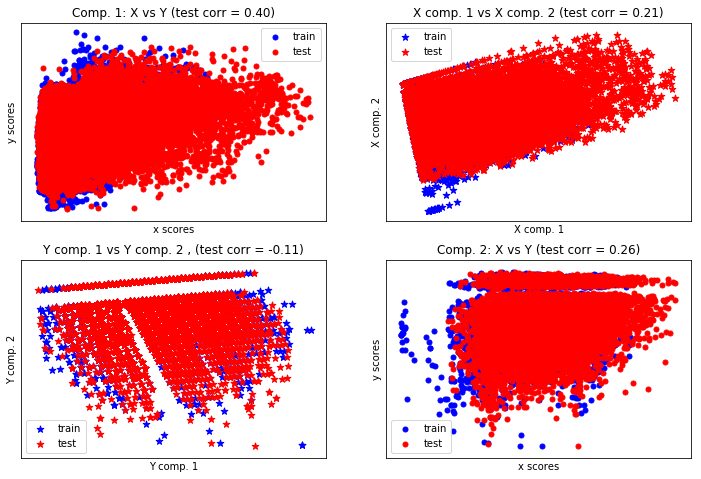

True B (such that: Y = XB + Err)
[[1 1 1]
 [2 2 2]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
Estimated B
[[ 1.   1.   1. ]
 [ 2.   2.   2. ]
 [ 0.   0.   0. ]
 [-0.  -0.  -0. ]
 [ 0.  -0.  -0.1]
 [ 0.   0.   0. ]
 [-0.  -0.  -0. ]
 [ 0.   0.  -0. ]
 [ 0.   0.   0. ]
 [ 0.1 -0.  -0.1]]
Estimated betas
[[ 1. ]
 [ 2.1]
 [-0. ]
 [ 0.1]
 [-0.1]
 [-0. ]
 [-0. ]
 [-0. ]
 [-0.1]
 [ 0. ]]


In [17]:
#Cross Decomposition

"""
Need to make my dataset more sparse.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA

# #############################################################################
# Dataset based latent variables model

n = 10000
# 2 latents vars:
X = df.as_matrix(columns = ['cnt', 'hum'])
Y = df.as_matrix(columns = ['atemp', 'windspeed'])

X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

print("Corr(X)")
print(np.round(np.corrcoef(X.T), 2))
print("Corr(Y)")
print(np.round(np.corrcoef(Y.T), 2))

# #############################################################################
# Canonical (symmetric) PLS

# Transform data
# ~~~~~~~~~~~~~~
plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())

plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())
plt.show()

# #############################################################################
# PLS regression, with multivariate response, a.k.a. PLS2

n = 1000
q = 3
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
B = np.array([[1, 2] + [0] * (p - 2)] * q).T
# each Yj = 1*X1 + 2*X2 + noize
Y = np.dot(X, B) + np.random.normal(size=n * q).reshape((n, q)) + 5

pls2 = PLSRegression(n_components=3)
pls2.fit(X, Y)
print("True B (such that: Y = XB + Err)")
print(B)
# compare pls2.coef_ with B
print("Estimated B")
print(np.round(pls2.coef_, 1))
pls2.predict(X)

# PLS regression, with univariate response, a.k.a. PLS1

n = 1000
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(size=n * 1) + 5
pls1 = PLSRegression(n_components=3)
pls1.fit(X, y)
# note that the number of components exceeds 1 (the dimension of y)
print("Estimated betas")
print(np.round(pls1.coef_, 1))

# #############################################################################
# CCA (PLS mode B with symmetric deflation)

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = cca.transform(X_train, Y_train)
X_test_r, Y_test_r = cca.transform(X_test, Y_test)

Corr(X)
[[ 1.    0.39]
 [ 0.39  1.  ]]
Corr(Y)
[[ 1.   -0.06]
 [-0.06  1.  ]]


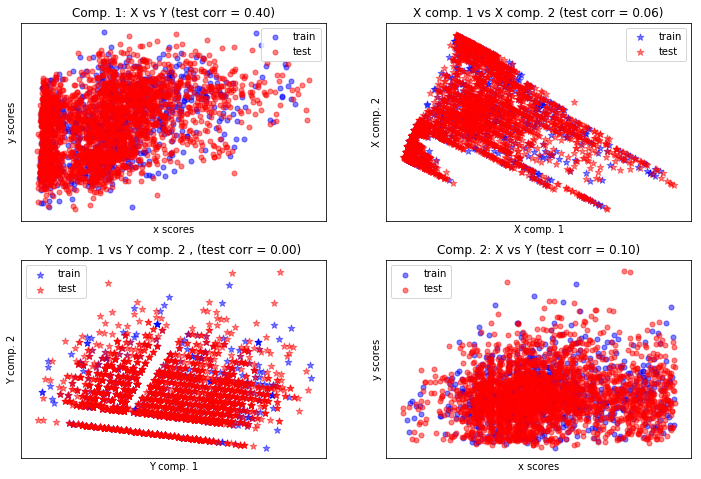

In [20]:
#Cross Decomposition

"""
Need to make my dataset more sparse.

Looking at the relations between [df['cnt], df['hr]] and [df['atemp'], df['windspeed']]
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA

# #############################################################################
# Dataset based latent variables model

df1 =  df.sample(frac = 0.2)

n = 1800
# 2 latents vars:
X = df1.as_matrix(columns = ['cnt', 'hr'])
Y = df1.as_matrix(columns = ['atemp', 'windspeed'])

X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

print("Corr(X)")
print(np.round(np.corrcoef(X.T), 2))
print("Corr(Y)")
print(np.round(np.corrcoef(Y.T), 2))

# #############################################################################
# Canonical (symmetric) PLS

# Transform data
# ~~~~~~~~~~~~~~
plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", alpha = 0.5, s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r",alpha = 0.5, s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", alpha = 0.5, s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r",alpha = 0.5, s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", alpha = 0.5,s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", alpha = 0.5,s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())

plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", alpha = 0.5,s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r",alpha = 0.5, s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())
plt.show()


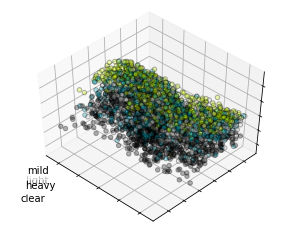

In [84]:
#Instruction 6: Decomposition:'

""" Noted that I need to sample from my data since I need to make them sparse.

However, it does not make much sense to me. 
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

df1 =  df.sample(frac = 0.2)
#centers = [[1, 1], [-1, -1], [1, -1]]


#X1 = df.drop(df["cnt"][df["weathersit"]==1].index, axis = 0)
#X = X1.as_matrix(columns = ['atemp', "windspeed", 'hum'])
#y = np.array(X1['workingday'])

X = df1.as_matrix(columns = ['atemp', "windspeed", 'hum', 'hr'])
y = np.array(df1['weathersit'])

fig = plt.figure(1, figsize=(4, 3))
plt.clf() #close current plot
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X = pca.transform(X)

for name, label in [("clear", 1), ("light", 2), ("mild", 3), ("heavy", 4)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), 
              #X[y == label, 3].mean()+2, 
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0, 3]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
           #X[:, 3], 
           c=y, cmap=plt.cm.spectral,
           edgecolor='k', alpha = 0.3)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])


plt.show()

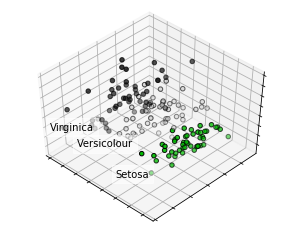

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

explained variance ratio (first two components): [ 0.92461621  0.05301557]


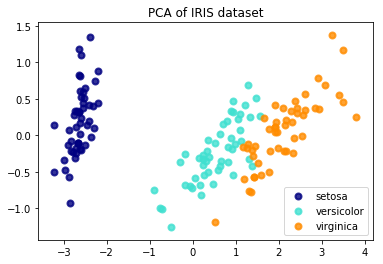

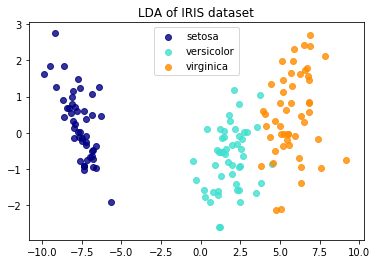

In [85]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

explained variance ratio (first two components): [  9.98326172e-01   7.44034224e-04]


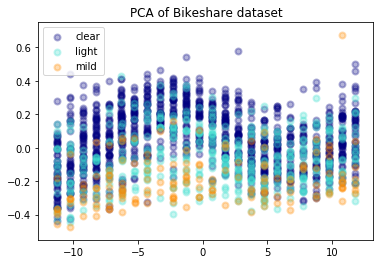

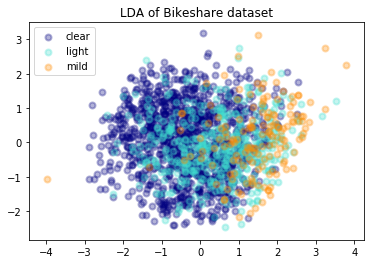

In [96]:
#Instruction 7: Provide an example of a Comparison of LDA and PCA 2D

""" Noted that "weathersit" started from 1, not 0. I recoded when plotting, regarding this problem.

"""



import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


df1 =  df.sample(frac = 0.1)

X = df1.as_matrix(columns = ['atemp', "windspeed", 'hum', 'hr'])
y = np.array(df1['weathersit'])

target_names = ["clear", "light", "mild"]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [1, 2, 3], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.3, lw=lw, 
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Bikeshare dataset')

plt.figure()
for color, i, target_name in zip(colors, [1, 2, 3], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.3, color=color, lw = lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Bikeshare dataset')

plt.show()

DecisionTree with features 0 has a score of 0.102991944764
RandomForest with 30 estimators with features 0 has a score of 0.102416570771
ExtraTrees with 30 estimators with features 0 has a score of 0.102991944764
AdaBoost with 30 estimators with features 0 has a score of 0.0397008055236
DecisionTree with features 1 has a score of 0.102991944764
RandomForest with 30 estimators with features 1 has a score of 0.102416570771
ExtraTrees with 30 estimators with features 1 has a score of 0.102991944764
AdaBoost with 30 estimators with features 1 has a score of 0.0397008055236


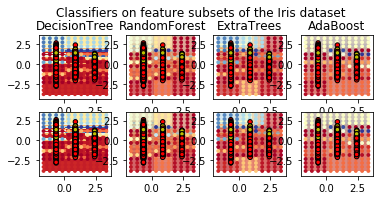

In [100]:
#Instruction 8: Provide an example of Plotting the decision surfaces of ensembles of trees using your dataset

""" I only checked the "weathersit" and "atemp" with "cnt", meaning I did not pair any features up.

Also, I sampled 10% of the whole dataset to make them sparse. 

"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

df1 =  df.sample(frac = 0.1)

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0,1]):
    for model in models:
        # We only take the two corresponding features
        X = df1.as_matrix(columns = ['weathersit', 'atemp'])
        y = np.array(df1['cnt'])

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()

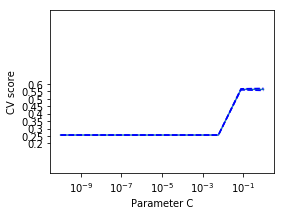

In [115]:
# Instruction 9: Provide an example of SVM using your dataset

""" Sampled 20% of the whole dataset. And using season as the y.

"""

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import datasets, svm

df1 =  df.sample(frac = 0.2)

X = df1.as_matrix(columns = ['atemp'])
y = np.array(df1['season'])

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

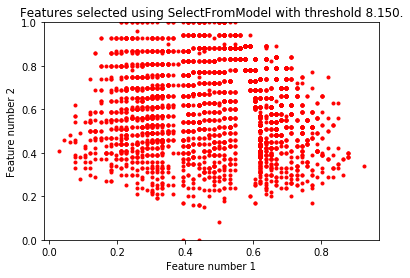

In [127]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# Load the boston dataset.
df1 =  df.sample(frac = 0.2)

X = df1.as_matrix(columns = ['atemp', "hum", "windspeed", "hr"])
y = np.array(df1['cnt'])

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]
    #print(sfm.get_params)

# Plot the selected two features from X.
plt.title(
    "Features selected using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1] 
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()



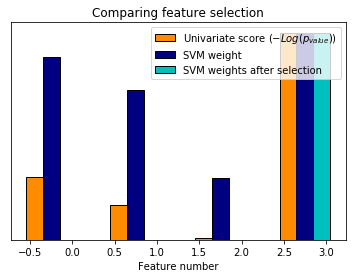

In [129]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif

# #############################################################################
# Import some data to play with

df1 =  df.sample(frac = 0.2)

X = df1.as_matrix(columns = ['atemp', "hum", "windspeed", "hr"])
y = np.array(df1['cnt'])

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

# #############################################################################
# Compare to the weights of an SVM
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c',
        edgecolor='black')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

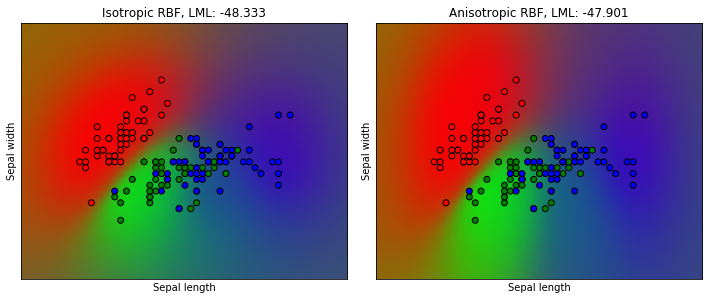

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = np.array(iris.target, dtype=int)
 
h = .02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# import some data to play with
df1 =  df.sample(frac = 0.01)

X = df1.as_matrix(columns = ['atemp', "hr"])
y = np.array(df1['cnt'])

h = .02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

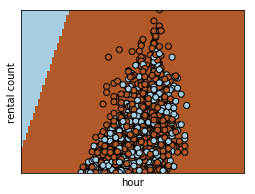

In [18]:
# Instruction 13: Provide an example of Plotting multi-class SGD on your dataset

""" This is for Logistic regression. However, for my dataset, it does not make sense since there is only one binary variable:
workingday.

However, this is not up for a prediction. So I just put the code here to show the code is working even though this might not mean
anything. 

"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

df1 =  df.sample(frac = 0.1)

X = df1.as_matrix(columns = ['atemp', 'cnt'])
y = np.array(df1['workingday'])

h = .02  # step size in the mesh

logreg = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('hour')
plt.ylabel('rental count')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [11]:
print(X.shape)
print(y.shape)

(3476, 2)
(3476,)


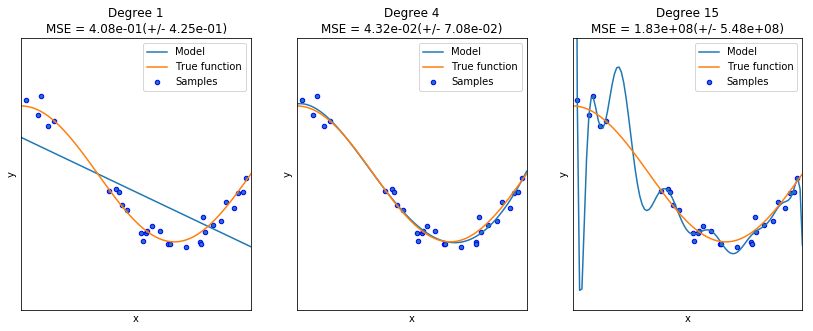

In [19]:
# Instruction 14: Provide an example of Underfitting vs. Overfitting using your dataset

""" There would be no True function in my data.

"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)



n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

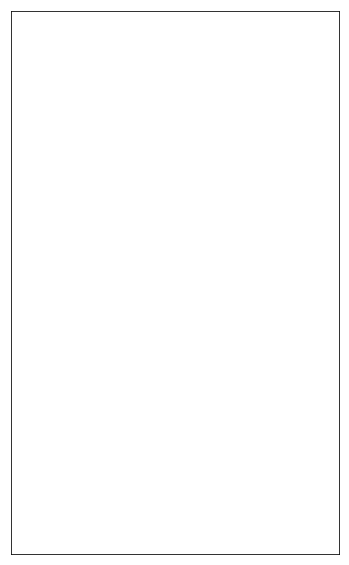

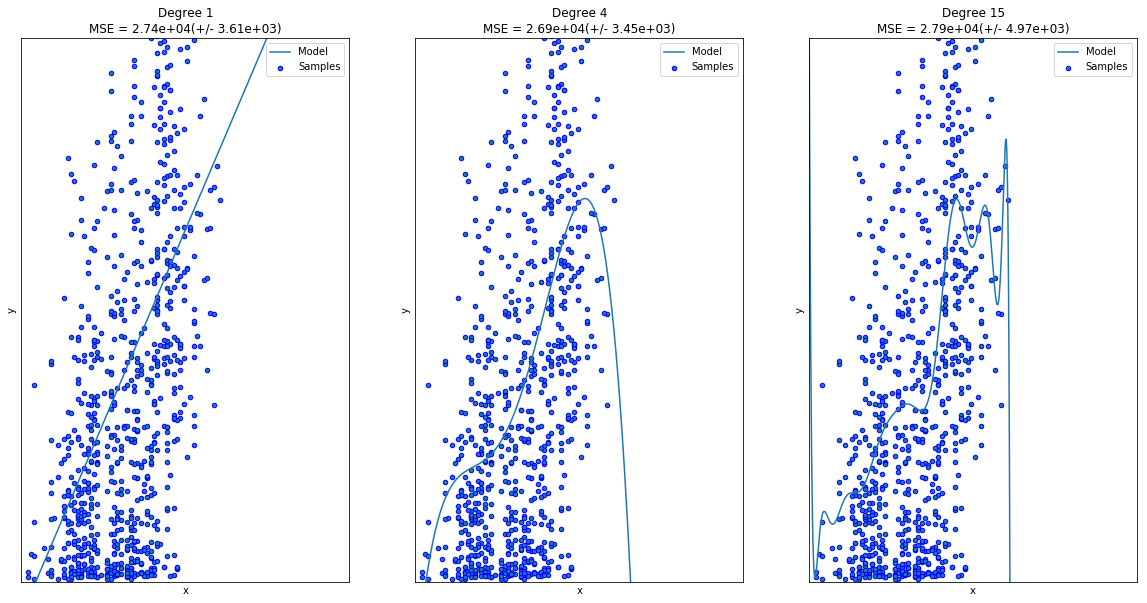

In [37]:
# Instruction 14: Provide an example of Underfitting vs. Overfitting using your dataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


df1 =  df.sample(frac = 0.05)

X = np.array(df1['atemp'])
y = np.array(df1['cnt'])

n_samples = 30
degrees = [1, 4, 15]


plt.figure(figsize=(20, 10))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 10, 5000)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1.5))
    plt.ylim((-2, 500))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

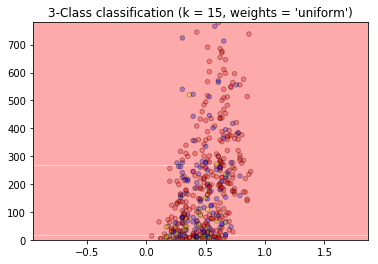

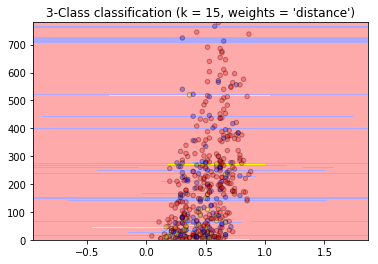

In [45]:
# Instruction 15: Provide an example of Nearest Neighbors Classification using your dataset.

""" Noticed that if I set the number of neighbors smaller, the effect is more dramatic for my data.
And I need to add another color map, since my weathersit has 4 values. 

"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

df1 =  df.sample(frac = 0.025)

X = df1.as_matrix(columns = ['atemp', 'cnt' ])
y = np.array(df1['weathersit'])

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', 'yellow'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', 'yellow'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha = 0.3,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


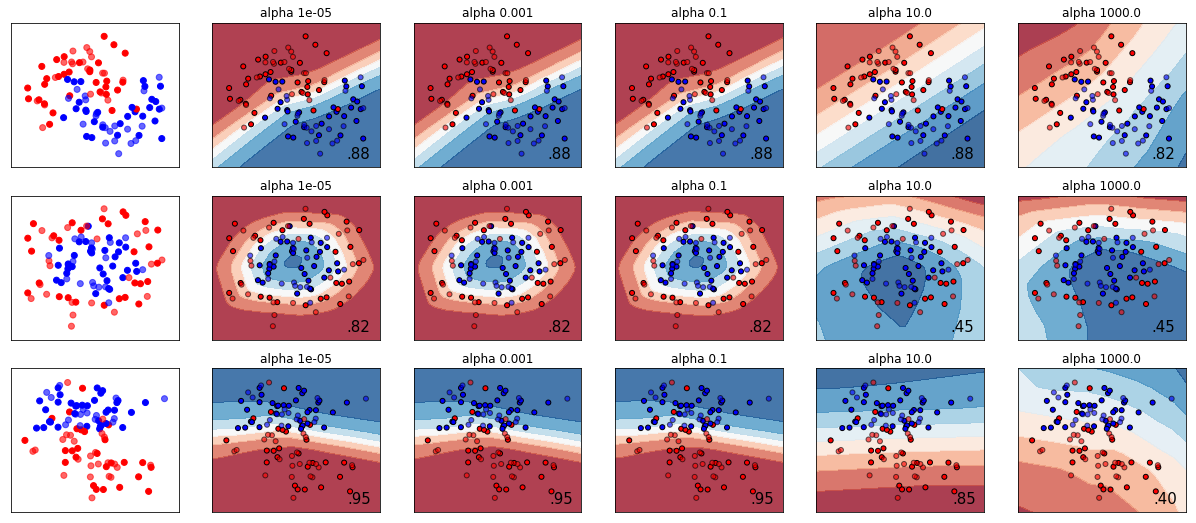

In [46]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier

h = .02  # step size in the mesh

alphas = np.logspace(-5, 3, 5)
names = []
for i in alphas:
    names.append('alpha ' + str(i))

classifiers = []
for i in alphas:
    classifiers.append(MLPClassifier(alpha=i, random_state=1))

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for X, y in datasets:
    # preprocess dataset, split into training and test part
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='black', s=25)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6, edgecolors='black', s=25)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

(434,)
(434, 2)

(434,)
(434, 2)

(434,)
(434, 2)



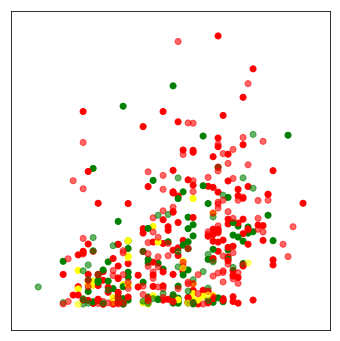

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


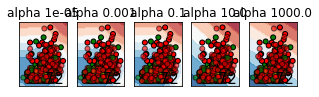

In [80]:
# Instruction 16: Provide an example of Varying regularization in Multi-layer Perceptron using your dataset

""" One set is completed.

"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier

df1 =  df.sample(frac = 0.025)


h = .02  # step size in the mesh

alphas = np.logspace(-5, 3, 5)
names = []
for i in alphas:
    names.append('alpha ' + str(i))

classifiers = []
for i in alphas:
    classifiers.append(MLPClassifier(alpha=i, random_state=1))

X = df1.as_matrix(columns = ['atemp', 'cnt' ])
y = np.array(df1['weathersit'])

#rng = np.random.RandomState(2)
#X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable]

figure = plt.figure(figsize=(40, 20))
i = 1
# iterate over datasets
#for X, y in datasets:
# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF', "green", "yellow"])
ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6) 
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

plt.show()

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='black', s=25)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6, edgecolors='black', s=25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
    i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

 I need to change the number of classes: 4 based on my dataset.



Prediction accuracy for the normal test dataset with PCA
63.81%


Prediction accuracy for the standardized test dataset with PCA
59.05%


PC 1 without scaling:
 [-0.00545077  0.00842878 -0.00252772 -0.00446688 -0.99993645]

PC 1 with scaling:
 [ 0.23611722 -0.61255589  0.501254   -0.20832582  0.52380218]


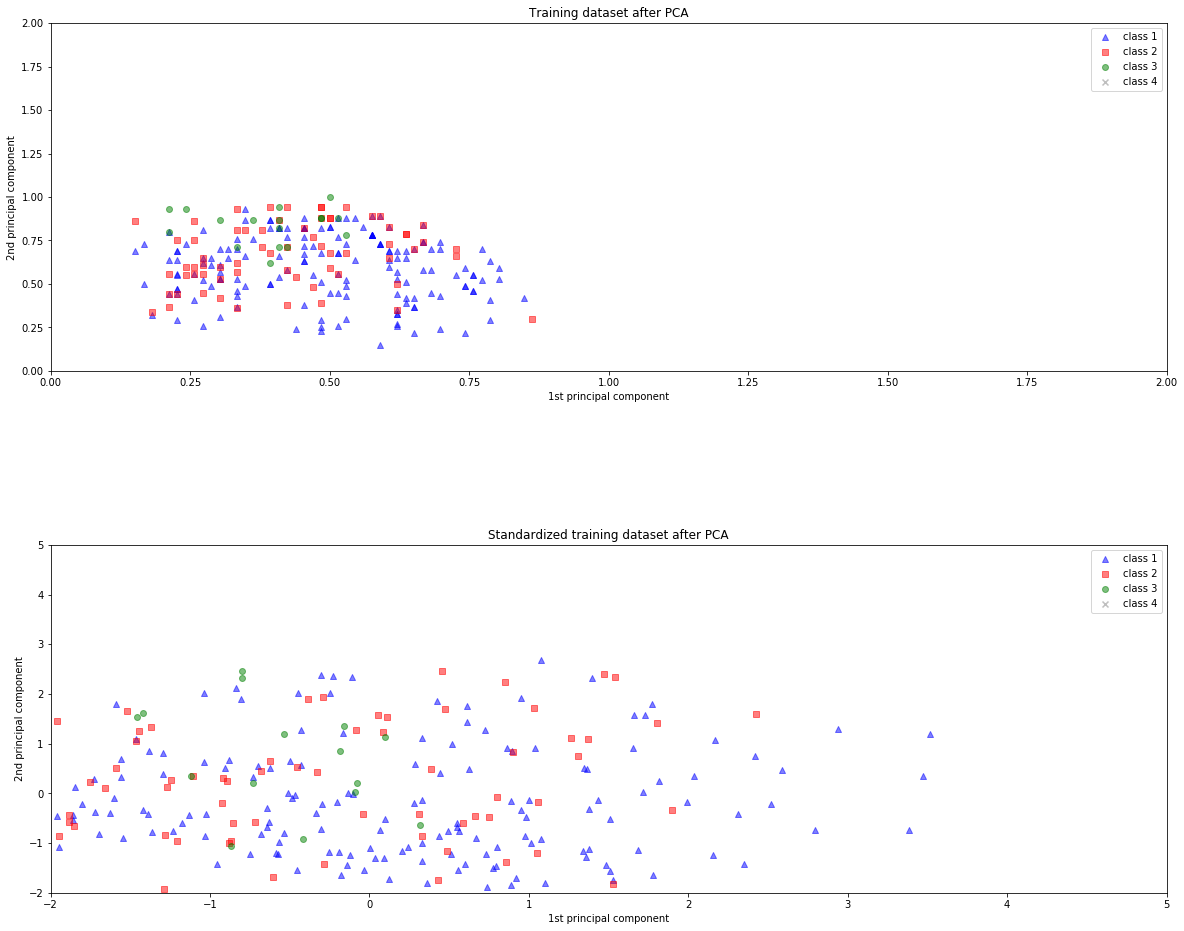

In [116]:
#Instruction 17: Provide an example of Importance of Feature Scaling using your dataset

""" I need to change the number of classes: 4 based on my dataset.

"""

from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
print(__doc__)

# Code source: Tyler Lanigan <tylerlanigan@gmail.com>
#              Sebastian Raschka <mail@sebastianraschka.com>

# License: BSD 3 clause

RANDOM_STATE = 42
FIG_SIZE = (10, 7)

df1 =  df.sample(frac = 0.02)

features = df1.as_matrix(columns = ['atemp', 'hum', 'windspeed', 'season', 'hr'])
target = np.array(df1['weathersit'])

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)

# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))

# Extract PCA from pipeline
pca = unscaled_clf.named_steps['pca']
pca_std = std_clf.named_steps['pca']

# Show first principal componenets
print('\nPC 1 without scaling:\n', pca.components_[0])
print('\nPC 1 with scaling:\n', pca_std.components_[0])

# Scale and use PCA on X_train data for visualization.
scaler = std_clf.named_steps['standardscaler']
X_train_std = pca_std.transform(scaler.transform(X_train))

# visualize standardized vs. untouched dataset with PCA performed
fig = plt.figure(figsize=(20, 16))

plt.subplots_adjust(hspace = 0.5) #Adjusting the space between subplots.

#Setting Subplots:
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


for l, c, m in zip(range(1, 5), ('blue', 'red', 'green', 'gray', 'yellow'), ('^', 's', 'o', 'x', 'o')):
    ax1.scatter(X_train[y_train == l, 0], X_train[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

for l, c, m in zip(range(1, 5), ('blue', 'red', 'green', 'gray', 'yellow'), ('^', 's', 'o', 'x', 'o')):
    ax2.scatter(X_train_std[y_train == l, 0], X_train_std[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('Training dataset after PCA')
ax2.set_title('Standardized training dataset after PCA')

ax1.set_xlim(0,2)
ax1.set_ylim(0,2)

ax2.set_xlim(-2,5)
ax2.set_ylim(-2,5)


#for ax in (ax1, ax2):
ax1.set_xlabel('1st principal component')
ax1.set_ylabel('2nd principal component')
ax1.legend(loc='upper right')

ax2.set_xlabel('1st principal component')
ax2.set_ylabel('2nd principal component')
ax2.legend(loc='upper right')

plt.show()

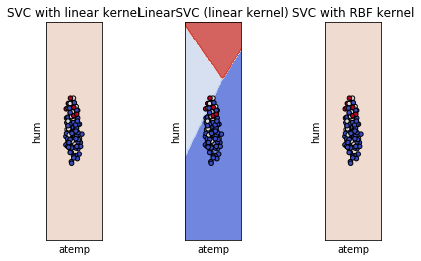

In [132]:
# Instruction 20: Provide an example of Plot different SVM classifiers in your dataset Comparison of different linear SVM classifiers on a 2D projection of the iris dataset. 

""" I did not run the poly, since based on my previous experience, it is going to take too much time. 

"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with

df1 =  df.sample(frac = 0.01)

X = df1.as_matrix(columns = ['atemp', 'hum'])
y = np.array(df1['weathersit'])
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C))
#svm.SVC(kernel='poly', degree=3, C=C)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel')
          
#'SVC with polynomial (degree 3) kernel'

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=1.5, hspace=1.5)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('atemp')
    ax.set_ylabel('hum')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

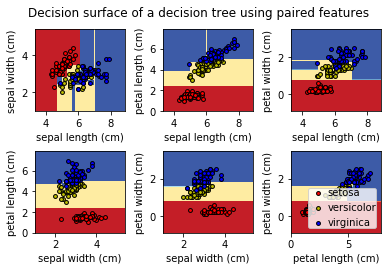

In [133]:
# Instruction 21: Provide an example of plotting the decision surface of a decision tree on your dataset

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

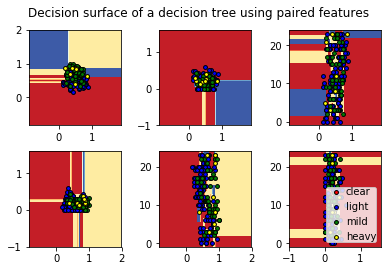

In [140]:
# Instruction 21: Provide an example of plotting the decision surface of a decision tree on your dataset

""" Learned a new way to pair the features together. I also changed the legend accordingly with my data. 

"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 4
plot_colors = ['red', 'blue', 'green', 'yellow']
plot_step = 0.02
labels = ["clear", 'light', 'mild', 'heavy']

# Load data
df1 =  df.sample(frac = 0.01)

X_lst = df1.as_matrix(columns = ['atemp', 'hum', 'windspeed', 'hr'])

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = X_lst[:, pair]
    y = np.array(df1['weathersit'])


    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    # Plot the training points
    for i, color, label in zip(range(n_classes), plot_colors, labels):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=label,
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()